In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py

path = '../Data/167/Lev5/' #path for the simulation
extrapolation_order = 2

alm = []
H2 = []

input_file1 = h5py.File(path+'rhOverM_Asymptotic_GeometricUnits.h5','r')
SXS = input_file1['Extrapolated_N%i.dir'%(extrapolation_order)]['Y_l%i_m%i.dat'%(2,-1)]
t = SXS[:,0]
dt = np.diff(t)

def ALM(l,m):
    #print("lol",l,m)
    if m>l or m<-l or l<2 or l>8:
        return 0
    return alm[l-2][m+l]
def Hcomp(l,m):
    if m>l or m<-l or l<2 or l>8:
        return 0
    return H2[l-2][m+l]
def norm(vector):
    return np.sqrt(vector[0]*vector[0]+vector[1]*vector[1]+vector[2]*vector[2])

meta = open(path+'metadata.txt','r')
for line in meta:
    line = line.translate(None,",")
    line = line.split()
    if(len(line)<2):
        continue;
    var = line[0].translate(None," ")
    if var == 'initial-ADM-energy':
        initial_mass = float(line[2])
    if var == 'initial-ADM-linear-momentum':
        initial_p = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'initial-ADM-angular-momentum':
        initial_j = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'remnant-mass':
        remnant_mass = float(line[2])
    if var == 'remnant-spin':
        remnant_spin = np.array([float(line[2]),float(line[3]),float(line[4])])

for l in range(2,9):
    alm.append([])
    H2.append([])
    for m in range(-l,l+1):
        SXS = input_file1['Extrapolated_N%i.dir'%(extrapolation_order)]['Y_l%i_m%i.dat'%(l,m)]
        H = SXS[:,1]+(0+1j)*SXS[:,2]
        t = SXS[:,0]
        Hdot = np.diff(H)/np.diff(t)
        alm[l-2].append(Hdot)
        H2[l-2].append(H[1:])

        
#The following are coefficients used in calculations of radiated angular and linear momentum       
def f(l,m):
    return np.sqrt((l-m)*(l+m+1))
def a(l,m):
    return np.sqrt((1.0+0j)*(l-m)*(l+m+1.0))/(l*(l+1.0))
def b(l,m):
    return (np.sqrt((1+0j)*(l-2.0)*(l+2.0)*(l+m)*(l+m-1.0)/(2.0*l-1.0)/(2.0*l+1.0)))/(2.0*l)
def c(l,m):
    return 2.0*m/(l*(l+1.0))
def d(l,m):
    return (np.sqrt((1.0+0j)*(l-2.0)*(l+2.0)*(l-m)*(l+m)/(2.0*l-1.0)/(2.0*l+1)))/l

for l in range(2,9):
    alm.append([])
    H2.append([])
    for m in range(-l,l+1):
        SXS = input_file1['Extrapolated_N2.dir']['Y_l%i_m%i.dat'%(l,m)]
        H = SXS[:,1]+(0+1j)*SXS[:,2]
        t = SXS[:,0]
        Hdot = np.diff(H)/np.diff(t)
        alm[l-2].append(Hdot)
        H2[l-2].append(H[1:])     
    

H2 = H2*1000

In [28]:
djx = (0+0j)*(dt)
djy = djx
djz = djx
for l in range(2,9):
    for m in range(-l,l+1):
        djx = djx + np.imag(Hcomp(l,m)*(f(l,m)*np.conj(ALM(l,m+1)) + f(l,-m)*np.conj(ALM(l,m-1))))
        djy = djy - np.real(Hcomp(l,m)*(f(l,m)*np.conj(ALM(l,m+1)) - f(l,-m)*np.conj(ALM(l,m-1))))
        djz = djz + np.imag(m*Hcomp(l,m)*np.conj(ALM(l,m)))
        
JX = np.real(np.cumsum(djx*dt)/(32*np.pi))
JY = np.real(np.cumsum(djy*dt)/(32*np.pi))
JZ = np.real(np.cumsum(djz*dt)/(16*np.pi))
J = np.array([JX,JY,JZ])
Total_J = norm(J)
Radiated_J = np.array([JX[-1],JY[-1],JZ[-1]])
Total_Radiated_J = norm(Radiated_J)
final_spin = initial_j - Radiated_J
final_total_spin = norm(final_spin)
remnant_total_spin = norm(remnant_spin)

Final Spin of Blackhole Calculated : [  1.01632197e-08  -1.51941172e-10   4.51323830e-01]
Final Spin of Blackhole from Horizon Data : [ -5.11332405e-06  -5.11332405e-06   4.50958000e-01]
Percentage Error from Horizon Data : [  1.00198760e+02   9.99970285e+01   8.11227640e-02] 
Magnitude of the final Angular Momentum : 0.451323829594
Percentage Error from Horizon Data : 0.0811227511459


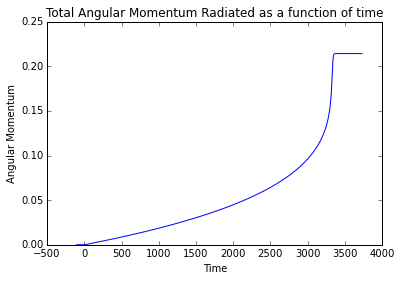

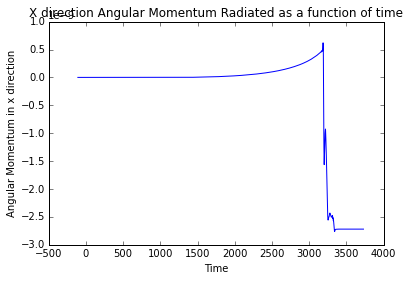

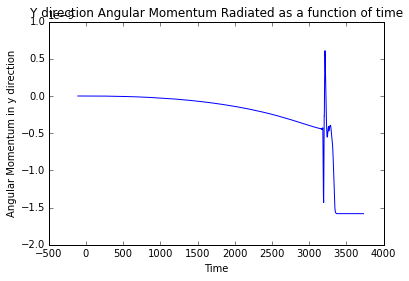

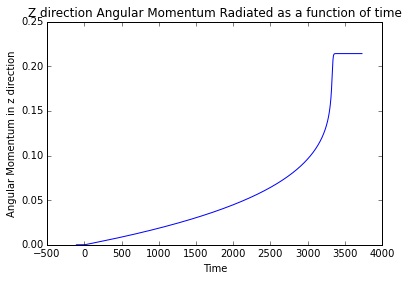

In [29]:
print("Final Spin of Blackhole Calculated : {}".format(final_spin))
print("Final Spin of Blackhole from Horizon Data : {}".format(remnant_spin))
print("Percentage Error from Horizon Data : {} ".format(np.abs(((final_spin-remnant_spin)/remnant_spin)*100)))
print("Magnitude of the final Angular Momentum : {}".format(final_total_spin))
print("Percentage Error from Horizon Data : {}".format(np.abs((final_total_spin-remnant_total_spin)/remnant_total_spin*100)))


plt.figure(1)
plt.title("Total Angular Momentum Radiated as a function of time")
plt.xlabel("Time")
plt.ylabel("Angular Momentum")
plt.plot(t[1:],Total_J)
plt.show()

plt.figure(2)
plt.title("X direction Angular Momentum Radiated as a function of time")
plt.xlabel("Time")
plt.ylabel("Angular Momentum in x direction")
plt.plot(t[1:],J[0])
plt.show()

plt.figure(3)
plt.title("Y direction Angular Momentum Radiated as a function of time")
plt.xlabel("Time")
plt.ylabel("Angular Momentum in y direction")
plt.plot(t[1:],J[1])
plt.show()

plt.figure(4)
plt.title("Z direction Angular Momentum Radiated as a function of time")
plt.xlabel("Time")
plt.ylabel("Angular Momentum in z direction")
plt.plot(t[1:],J[2])
plt.show()

